In [25]:
# CS194-26 (CS294-26): Project 1 starter Python code

# these are just some suggested libraries
# instead of scikit-image you could use matplotlib and opencv to read, write, and display images

import numpy as np
import skimage as sk
import skimage.io as skio
from skimage.transform import rescale, resize, downscale_local_mean
import os

In [26]:
# MSE: This is used to find the "differences" between two images
def mse(image1, image2):
    num_pixels = image1.shape[0]*image1.shape[1]
    ssd_value = np.sum((image1-image2)**2)
    return ssd_value/num_pixels

In [27]:
# Generating all possible start x,y indices.
# In this case, image2 is the bigger image and image1 is the cropped image. 
# We compute the mse with the cropped image1 against various cropped sections of image2
# and pick which cropped section of image2 results in the lowest mse
def align_small(image1, image2):
    min_mse = float('inf') 
    min_image = None
    image1_width = image1.shape[1]
    image1_height = image1.shape[0]
    min_width = 0
    min_height = 0
    for w in range(0, image2.shape[1]-image1_width):
        for h in range(0, image2.shape[0]-image1_height):
            image2_cropped = image2[h:(h+image1_height), w:(w+image1_width)]
            mse_value = mse(image1, image2_cropped)
            if(mse_value < min_mse):
                min_mse = mse_value
                min_image = image2_cropped
                min_width = w
                min_height = h
    return (min_mse, min_image, min_width, min_height)

In [28]:
# This function takes in an image and crops the width and height by ten percent
def crop_ten(image):
    ten_percent_width = int(round(0.1 * image.shape[1]))
    cropped_width = image.shape[1] - 2*ten_percent_width
    
    ten_percent_height = int(round(0.1 * image.shape[0]))
    cropped_height = image.shape[0] - 2*ten_percent_height
    
    cropped = image[ten_percent_height:(ten_percent_height+cropped_height), ten_percent_width:(ten_percent_width+cropped_width)]
    return cropped

In [29]:
# This function runs the logic for the smaller .jpg images
def small_jpg_images(r,b,g):
    # First, we crop the green glass plate image
    g_cropped = crop_ten(g)

    # We align the cropped green against the blue image to find which section of the blue
    # images results in the lowest mse with the cropped green image
    (min_mse_bg, blue_image, bw, bh) = align_small(g_cropped, b)
    # We align the cropped green against the red image to find which section of the red
    # images results in the lowest mse with the cropped green image
    (min_mse_rg, red_image, rw, rh) = align_small(g_cropped, r)

    return (red_image, rw, rh, g_cropped, blue_image, bw, bh)

In [30]:
def generate_pyramid_layers(layers, image):
    if(image.shape[0] == 0 or image.shape[1] == 0):
        return layers
    if(image.shape[0] <= 50 or image.shape[1] <=50):
        layers += [image]
        return layers
    reduced_image = sk.transform.resize(image, (round(int(image.shape[0] // 2)), round(int(image.shape[1] // 2))), anti_aliasing=True)
    layers = generate_pyramid_layers(layers, reduced_image)
    layers += [image]
    return layers


In [31]:
def align_big(other_layers, base_layers):
    # base = cropped, other = full 
    min_image = None
    
    (min_mse, image, prev_w, prev_h) = align_small(base_layers[0],other_layers[0])
    min_w = prev_w
    min_h = prev_h 
    for index in range(1, len(base_layers)):
        min_mse = float('inf') 
        base = base_layers[index]
        other = other_layers[index]
        base_width = base.shape[1]
        base_height = base.shape[0]
        temp_prev_w = prev_w
        temp_prev_h = prev_h
        for w in range(max((prev_w-1)*2, 0), min((prev_w+1)*2, other.shape[1] - base_width)):
            for h in range(max((prev_h-1)*2, 0), min((prev_h+1)*2, other.shape[0] - base_height)):
                other_cropped = other[h:(h+base_height), w:(w+base_width)]
                mse_value = mse(other_cropped, base)
                if(mse_value < min_mse):
                    min_mse = mse_value
                    min_image = other_cropped
                    min_w = w
                    min_h = h 
                    temp_prev_w = w
                    temp_prev_h = h
        prev_w = temp_prev_w
        prev_h = temp_prev_h
    return (min_image, min_w, min_h)

In [32]:
def bigger_images(r,b,g):
    # crop image
    g_cropped = crop_ten(g)

    g_layers = []
    r_layers = []
    b_layers = []

    g_layers = generate_pyramid_layers(g_layers, g_cropped)
    r_layers = generate_pyramid_layers(r_layers, r)
    b_layers = generate_pyramid_layers(b_layers, b)

    # print(len(g_layers))
    # print(len(r_layers))
    # print(len(g_layers))

    (red_image, rw, rh) = align_big(r_layers, g_layers)
    (blue_image, bw, bh) = align_big(b_layers, g_layers)

    # Crop g
    # Generate pyramid layers through recursion
    # Align (Green & Red) and (Green & Blue) through each layer, updating each position points
    return (red_image, rw, rh, g_cropped, blue_image, bw, bh)

In [33]:
def run_everything(imname):
    # read in the image
    im = skio.imread(INPUT_PATH + imname)
    name_len = len(imname)
    
    # convert to double (might want to do this later on to save memory)    
    im = sk.img_as_float(im)

    # compute the height of each part (just 1/3 of total)
    height = np.floor(im.shape[0] / 3.0).astype(np.int)

    # separate color channels
    b = im[:height]
    g = im[height: 2*height]
    r = im[2*height: 3*height]
    
    if(imname[name_len-3:name_len] == "jpg"):
        (red_image, rw, rh, g_cropped, blue_image, bw, bh) = small_jpg_images(r,b,g)
    elif(imname[name_len-3:name_len] == "tif"):
        (red_image, rw, rh, g_cropped, blue_image, bw, bh) = bigger_images(r,b,g)
    
    # create a color image
    im_out = np.dstack([red_image, g_cropped, blue_image])
    
    # save the image
    fname = "out_path/" + imname[:name_len-3] +"jpg"
    skio.imsave(fname, im_out)
    
    # display the image
    skio.imshow(im_out)
    skio.show()
    print("******* Image: " + imname + " *********")
    print("R(" + str(rw) + ", " + str(rh) +")")
    print("B(" + str(bw) + ", " + str(bh) +")")

In [34]:

INPUT_PATH = "data/"
def main():
    #names = ["data/castle.tif","data/cathedral.jpg","data/emir.tif", "data/harvesters.tif","data/icon.tif","data/lady.tif","data/melons.tif","data/monastery.jpg","data/onion_church.tif","data/self_portrait.tif","data/three_generations.tif","data/tobolsk.jpg","data/train.tif","data/workshop.tif"]
    for name in os.listdir(INPUT_PATH):
        run_everything(name)
        

/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


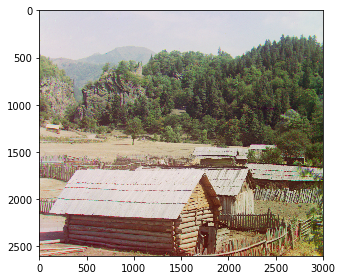

******* Image: castle.tif *********
R(374, 261)
B(378, 360)


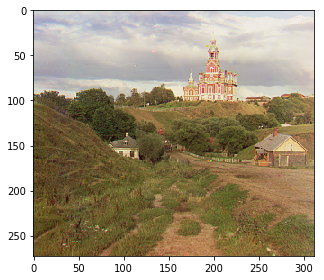

******* Image: cathedral.jpg *********
R(38, 27)
B(41, 39)


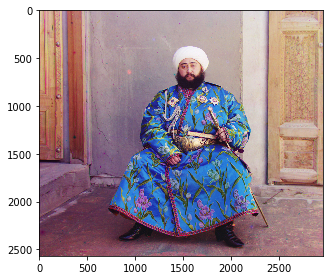

******* Image: emir.tif *********
R(353, 264)
B(394, 370)


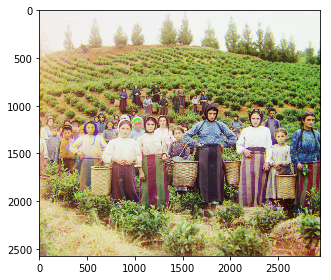

******* Image: harvesters.tif *********
R(371, 257)
B(384, 381)


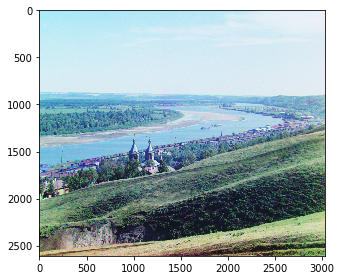

******* Image: hills.tif *********
R(398, 258)
B(362, 379)


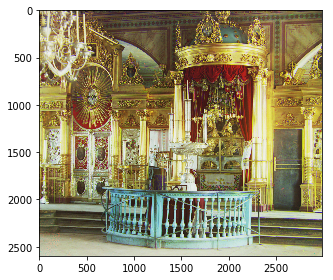

******* Image: icon.tif *********
R(369, 276)
B(391, 365)


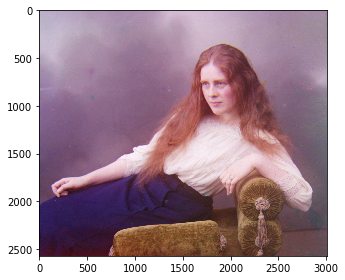

******* Image: lady.tif *********
R(373, 259)
B(384, 377)


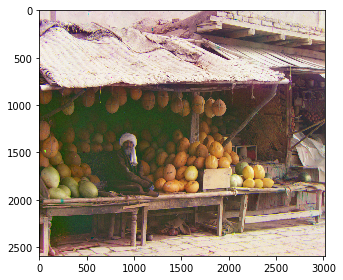

******* Image: melons.tif *********
R(373, 228)
B(388, 406)


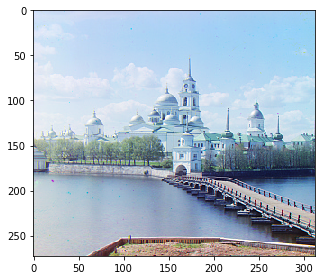

******* Image: monastery.jpg *********
R(38, 28)
B(41, 31)


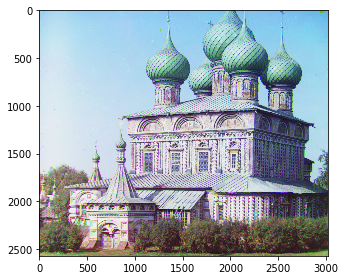

******* Image: onion_church.tif *********
R(368, 265)
B(405, 373)


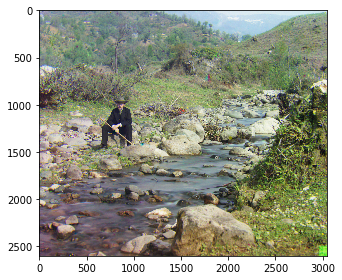

******* Image: self_portrait.tif *********
R(373, 227)
B(410, 404)


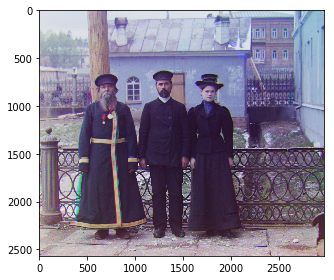

******* Image: three_generations.tif *********
R(374, 263)
B(385, 374)


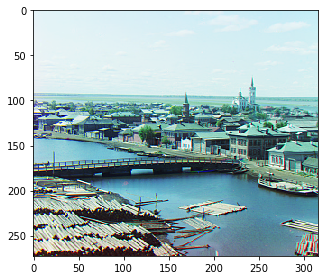

******* Image: tobolsk.jpg *********
R(39, 30)
B(43, 37)


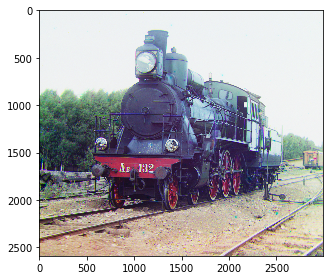

******* Image: train.tif *********
R(347, 281)
B(380, 367)


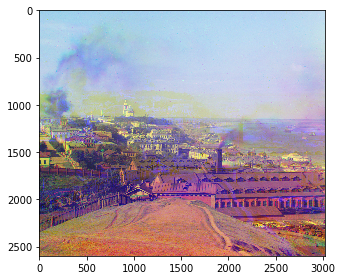

******* Image: valley.tif *********
R(394, 266)
B(133, 639)


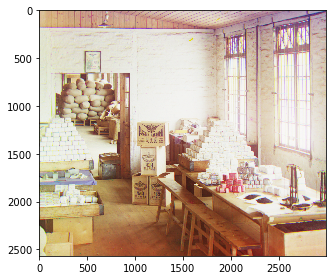

******* Image: workshop.tif *********
R(385, 269)
B(374, 374)


In [35]:
main()